 # Exploration et analyse des données - Classification (DL I)

## 1. Introduction et Objectifs

- Présentation du projet : classification d’images agricoles prises dans un champ de maïs à l’aide de réseaux de neurones convolutifs (CNN).

- Objectif principal : développer un modèle capable d’identifier automatiquement la zone photographiée parmi plusieurs classes (sol nu, maïs, mauvaises herbes, mélange maïs et mauvaises herbes) pour optimiser l’irrigation et la gestion des cultures.

- Modules concernés : Deep Learning I (modélisation CNN), Machine Learning II (explicabilité), MLOps (structuration du pipeline).

- Enjeux : améliorer la prise de décision agricole grâce à l’IA, automatiser l’analyse d’images terrain, et expérimenter différentes architectures et techniques de deep learning.

## 2. Préparation des bibliothèques

### 2.1 Import des bibliothèques

In [1]:
import os
import shutil
import kagglehub

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from pathlib import Path
from PIL import Image

from tensorflow.keras.utils import image_dataset_from_directory

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Liste des constante
data_dir = '../data'
dataset_handle = "rodrigonuneswessner/labeledcorndataset"
base_path = os.path.join('..', 'data', 'ImagensTCCRotuladas') # Dataset d'origine
absolut_path = os.path.abspath(base_path) #Chemin absolu du dataset d'origine
sets = ['Treino', 'Valid', 'Teste'] # Nom des dossier du datasets d'origine
dst_dir = os.path.join(base_path, 'mini_img') # Dataset modifié à exploiter
IMG_SIZE = (64, 64) # Taille des images du dataset à exploiter
BATCH_SIZE = 32 # traitement des images par groupe de 32

# Fixer tous les seeds pour la reproductibilité
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Configurer TensorFlow pour la reproductibilité
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.experimental.enable_op_determinism()

### 2.2 Récupération des données sur kaggle

In [3]:
if not os.path.exists(os.path.join(data_dir, 'ImagensTCCRotuladas')):
    print("Téléchargement...")
    # Télécharger directement le dataset complet
    path = kagglehub.dataset_download(dataset_handle)

    print("Dataset téléchargé dans :", path)

    path_dataset_to_move = os.path.join(path, 'ImagensTCCRotuladas', 'ImagensTCCRotuladas') # Dossier à déplacer

    path_temp_datasets = os.path.expanduser('~/.cache/kagglehub/datasets')
    path_temp_to_remove = os.path.join(path_temp_datasets, 'rodrigonuneswessner') # Supprime le cache

    shutil.move(path_dataset_to_move, data_dir)
    shutil.rmtree(path_temp_to_remove)

    # Renomme le fichier mal encoder
    name_to_repare_folder = 'Valida├º├úo'
    folder_to_rename = Path(data_dir, 'ImagensTCCRotuladas',name_to_repare_folder)
    folder_rename = Path(data_dir, 'ImagensTCCRotuladas', sets[1])
    folder_to_rename.rename(folder_rename)
    print("Dataset déplacé dans le projet :", data_dir)
else:
    print("Dataset déjà présent.")


Dataset déjà présent.


## 3. Analyse Exploratoire des Données (EDA)


--- Treino ---
Chao : 6134 images


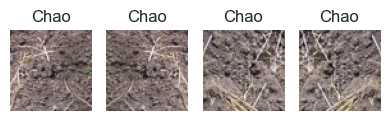

Ervas : 6015 images


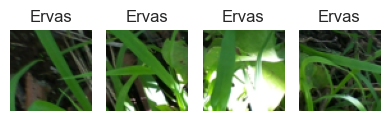

Milho : 6255 images


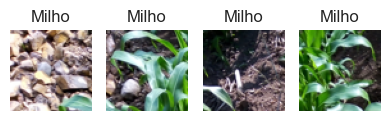

Milho_ervas : 6040 images


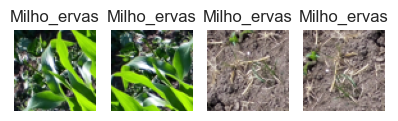


--- Valid ---
Chao : 646 images


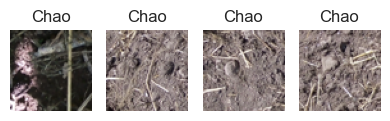

Ervas : 668 images


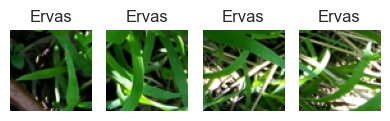

Milho : 695 images


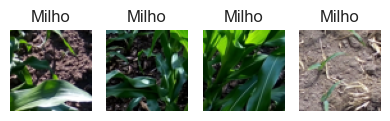

Milho_ervas : 670 images


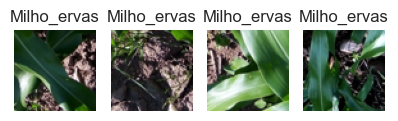


--- Teste ---
Chao : 100 images


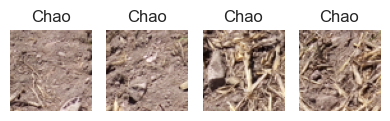

Ervas : 100 images


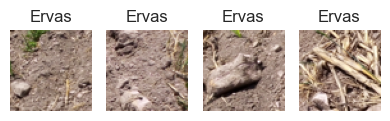

Milho : 100 images


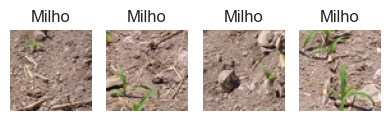

Milho_ervas : 100 images


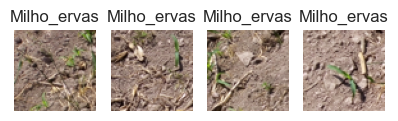

In [4]:
for set_name in sets:
    print(f"\n--- {set_name} ---")
    set_path = os.path.join(base_path, set_name)
    classes = os.listdir(set_path)
    for cls in classes:
        class_path = os.path.join(set_path, cls)
        images = os.listdir(class_path)
        print(f"{cls} : {len(images)} images")
        fig, axs = plt.subplots(1, 4, figsize=(4, 2))
        for i, img_name in enumerate(images[:4]):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            img = img.resize((64, 64))
            axs[i].imshow(img)
            axs[i].set_title(cls)
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()

- **Répartition des classes** : Chaque set (train, validation, test) contient bien les 4 classes: Chao (sol), Ervas (mauvaises herbes), Milho (maïs), Milho_ervas (maïs et mauvaises herbes).
- **Équilibre général** : Dans le jeu d’entraînement, toutes les classes sont relativement équilibrées (entre 6000 et 6300 images par classe).
- **Validation/Test** :
    - Validation: classes équilibrées (environ 650 images par classe).
    - Test: strictement équilibré (100 images par classe).
- **Affichage des images** : Pour chaque classe, on affiche 3 exemples représentatifs. Cela permet de visualiser la diversité des images (sol nu, maïs seul, herbes, ou mélange de maïs et herbes).
- **Taille des images** : Les images sont redimensionnées à 64x64 pixels pour faciliter le traitement et accélérer l’entraînement.

Le dataset est bien structuré, équilibré, et prêt pour le nettoyage et le prétraitement.

## 4. Préparation des données

Les fichiers sont dupliqué pour être transformé sans risque de modification sur les données original et les images sont vérifié au cas ou elle sont corrompu.

### 4.1 Nettoyage des données

In [5]:
os.makedirs(dst_dir, exist_ok=True)

if not os.path.exists(os.path.join(data_dir, 'ImagensTCCRotuladas', 'mini_img')):
    for set_name in sets:
        set_path = os.path.join(base_path, set_name)

        dest_set_path = os.path.join(dst_dir, set_name)
        os.makedirs(dest_set_path, exist_ok=True)

        for root, dirs, files in os.walk(set_path):
            for file in files:
                src_path = os.path.join(root, file)
                dest_path = os.path.join(dest_set_path, file)

                try:
                    img = Image.open(src_path)
                    img_redim = img.resize(IMG_SIZE)
                    img_redim.save(dest_path)
                    try:
                        with Image.open(dest_path) as img_check:
                            img_check.verify()
                        with Image.open(dest_path) as img_check:
                            img_check.load()
                    except Exception as e:
                        print(f"Image corrompue {dest_path} : {e}")
                        os.remove(dest_path)
                except Exception as e:
                    print(f"Erreur avec {src_path} : {e}")

Toutes les images redimentionnés sont ouvertes et testées.
Les images corrompues sont identifiées, affichées à l’écran, puis supprimées.
À la fin du traitement, le nombre d’images valides et le nombre d’images corrompues supprimées sont affichés pour chaque classe.

### 4.2 Division train/validation/test

Les images sont déjà organisées dans des dossiers distincts dédiés à l’entraînement (train), à la validation (val) et au test (test). Cela permet de garantir que les données d’entraînement, de validation et de test ne se mélangent pas, ce qui évite tout biais dans l’évaluation du modèle. Il n’est donc pas nécessaire de réaliser une division supplémentaire : chaque ensemble de données est directement exploitable à partir de son dossier respectif.

In [6]:
print('Chargement de ', os.path.join(absolut_path, sets[0]))
train_dataset = image_dataset_from_directory(
    os.path.join(absolut_path, sets[0]),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Nombre de batches de test : {len(train_dataset)}")
print(f"Classes détectées : {train_dataset.class_names}")

print('---------------------------------------------------')

print('Chargement de ', os.path.join(absolut_path, sets[1]))
val_dataset = image_dataset_from_directory(
    os.path.join(absolut_path, sets[1]),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Nombre de batches de test : {len(val_dataset)}")
print(f"Classes détectées : {val_dataset.class_names}")

print('---------------------------------------------------')

print('Chargement de ', os.path.join(absolut_path, sets[2]))
test_dataset = image_dataset_from_directory(
    os.path.join(absolut_path, sets[2]),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"Nombre de batches de test : {len(test_dataset)}")
print(f"Classes détectées : {test_dataset.class_names}")

class_names = train_dataset.class_names

Chargement de  C:\projets\mesp2-laurent-sini\data\ImagensTCCRotuladas\Treino
Found 24444 files belonging to 4 classes.
Nombre de batches de test : 764
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
---------------------------------------------------
Chargement de  C:\projets\mesp2-laurent-sini\data\ImagensTCCRotuladas\Valid
Found 2679 files belonging to 4 classes.
Nombre de batches de test : 84
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']
---------------------------------------------------
Chargement de  C:\projets\mesp2-laurent-sini\data\ImagensTCCRotuladas\Teste
Found 400 files belonging to 4 classes.
Nombre de batches de test : 13
Classes détectées : ['Chao', 'Ervas', 'Milho', 'Milho_ervas']


Aperçu des images après chargement et redimensionnement.

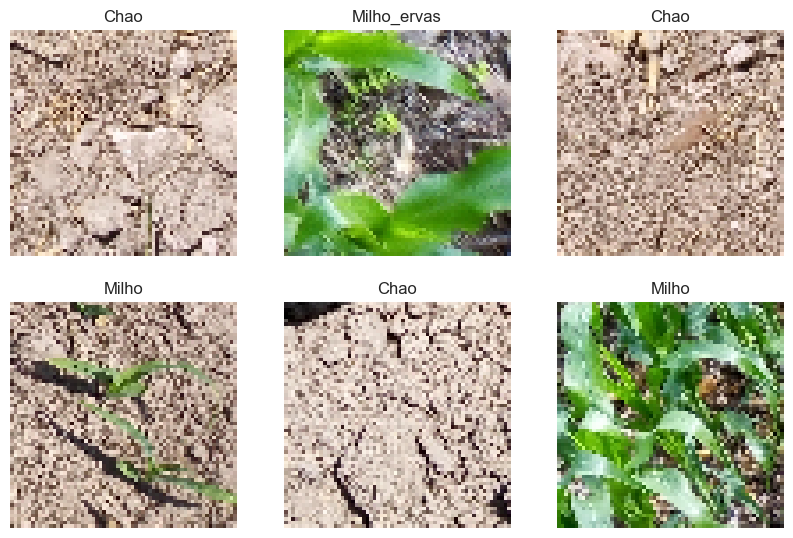

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(test_dataset.class_names[labels[i]])
        plt.axis("off")

### 4.3 Normalisation des pixels

La normalisation consiste à transformer les valeurs des pixels des images pour qu’elles soient comprises entre 0 et 1, au lieu de 0 à 255.

**Avantages** :
- **Accélère l’apprentissage** : Les réseaux de neurones convergent plus vite quand les données sont sur une échelle similaire.
- **Améliore la stabilité** : Cela évite que de grandes valeurs de pixels ne perturbent le calcul des gradients pendant l’entraînement.
- **Compatibilité** : Les modèles pré-entraînés et la plupart des architectures de deep learning attendent des images normalisées.

On applique cette normalisation à tous les jeux de données (entraînement, validation, test) pour garantir la cohérence des prédictions et de l’évaluation.

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

### 4.4 Augmentation de données

Augmentation de données sur le dataset d’entraînement pour :
- Générer artificiellement plus de diversité à partir de nos images existantes (ex : retournement, rotation, zoom).
- Rendre le modèle plus robuste : il apprend à reconnaître les objets même si l’image est un peu différente (angle, luminosité, etc.).
- Éviter le surapprentissage (overfitting) : le modèle ne mémorise pas juste les images d’entraînement, il apprend à généraliser.
- Améliorer la précision et la capacité de généralisation du modèle sur de nouvelles images.

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=42),
    tf.keras.layers.RandomRotation(0.1, seed=42),
    tf.keras.layers.RandomZoom(0.1, seed=42)
])

train_dataset_augmented = train_dataset.shuffle(buffer_size=10000, seed=42).map(
    lambda x, y: (data_augmentation(x, training=True), y)
).cache()


## 5. Modélisation

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]


### 5.1 CNN

In [11]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(4)
    ])

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'adagrad']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

# Créer le tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=6,
    directory='tuner_results',
    project_name='corn_classification'
)

train_subset = train_dataset_augmented.take(len(train_dataset_augmented)//3)
val_subset = val_dataset.take(len(val_dataset)//2)

tuner.search(
    train_subset,
    validation_data=val_subset,
    epochs=3,
    verbose=0
)

best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_acc = best_model.evaluate(test_dataset, verbose=0)
print(f"Meilleure accuracy: {test_acc:.4f}")

Reloading Tuner from tuner_results\corn_classification\tuner0.json



C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Meilleure accuracy: 0.6600


In [12]:
best_hps = tuner.get_best_hyperparameters()[0]

print("=== MEILLEURS HYPERPARAMÈTRES ===")
print(f"Optimizer: {best_hps.get('optimizer')}")
print(f"Dropout: {best_hps.get('dropout')}")


=== MEILLEURS HYPERPARAMÈTRES ===
Optimizer: adam
Dropout: 0.4


In [13]:
final_model = tuner.hypermodel.build(best_hps)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = final_model.fit(
    train_dataset_augmented,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 157s 102ms/step - accuracy: 0.4593 - loss: 1.1298 - val_accuracy: 0.5416 - val_loss: 0.9675
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 133s 99ms/step - accuracy: 0.6228 - loss: 0.8579 - val_accuracy: 0.5995 - val_loss: 0.8426
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 139s 102ms/step - accuracy: 0.6517 - loss: 0.7866 - val_accuracy: 0.6573 - val_loss: 0.7416
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 132s 101ms/step - accuracy: 0.6605 - loss: 0.7568 - val_accuracy: 0.6667 - val_loss: 0.7033
Epoch 5/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 169s 144ms/step - accuracy: 0.6825 - loss: 0.7094 - val_accuracy: 0.6618 - val_loss: 0.6817
Epoch 6/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 154s 115ms/step - accuracy: 0.6899 - loss: 0.6872 - val_accuracy: 0.6872 - val_loss: 0.6544
Epoch 7/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 149s 115ms/step - accuracy: 0.6916 - loss: 0.6776 - val_accuracy: 0.6629 - val_loss: 0.6495
Epoch 8/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 161s 127ms/step - accuracy: 0.6977 - 

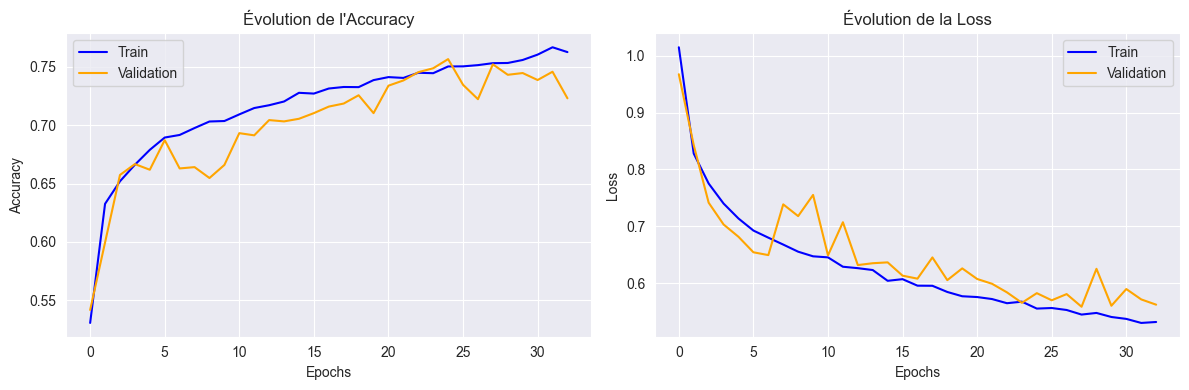

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', color='orange')
ax1.set_title('Évolution de l\'Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train', color='blue')
ax2.plot(history.history['val_loss'], label='Validation', color='orange')
ax2.set_title('Évolution de la Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Ces résultats démontrent l'efficacité de l'architecture CNN retenue et des hyperparamètres optimisés via Keras Tuner. Le modèle atteint des performances satisfaisantes avec une accuracy finale d'environ 75% sur un problème de classification multi-classes complexe impliquant des textures végétales similaires. L'utilisation de techniques de régularisation (dropout, early stopping) permet d'obtenir un équilibre optimal entre capacité d'apprentissage et généralisation.

In [33]:
final_test_loss, final_test_acc = final_model.evaluate(test_dataset, verbose=0)

print("\n=== RÉSULTATS FINAUX ===")
print(f"Accuracy sur test: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"Loss sur test: {final_test_loss:.4f}")



=== RÉSULTATS FINAUX ===
Accuracy sur test: 0.7525 (75.25%)
Loss sur test: 0.5027


C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


**Résultats encourageants** : Le modèle atteint une accuracy finale de **~75%** sur le jeu de test, démontrant une bonne capacité de généralisation malgré la complexité du problème (classification de textures végétales similaires).

**Instabilité de la validation** : Les fortes fluctuations de l'accuracy de validation (oscillations entre 66% et 71%) suggèrent que le dataset de validation est potentiellement limité ou que certaines classes sont difficiles à distinguer. Cette variabilité est courante dans les problèmes de vision par ordinateur avec des classes visuellement proches.

**Convergence effective** : Malgré l'instabilité apparente, le modèle final performe mieux sur le test que la moyenne de validation (~68-69%), indiquant une bonne robustesse de l'architecture retenue.

**Early stopping justifié** : L'arrêt à l'epoch 21 semble approprié car les courbes de loss se stabilisent, évitant un surapprentissage excessif.

---

On "défait" et reforme les batches pour s'assurer que les données sont bien alignées et dans le bon ordre. Cela garantit que chaque prédiction correspond exactement à sa vraie étiquette, ce qui est essentiel pour calculer correctement les métriques comme la matrice de confusion.

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Accuracy sur test: 0.7525 (75.25%)

Vérification des tailles:
y_true shape: (400,)
y_pred_classes shape: (400,)


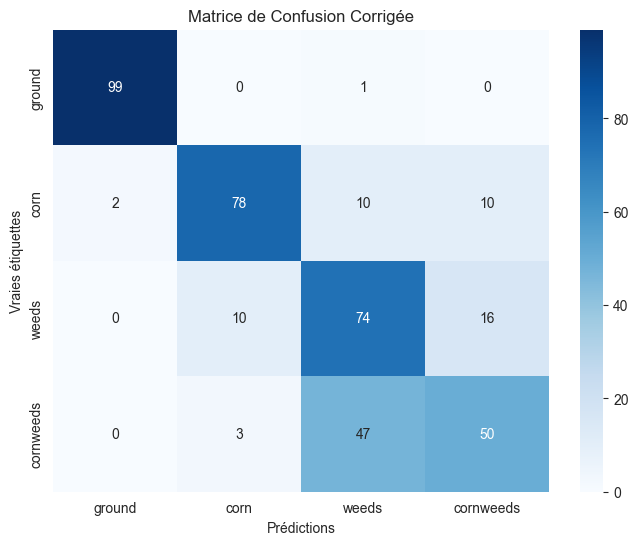


=== RAPPORT DÉTAILLÉ CORRIGÉ ===
              precision    recall  f1-score   support

      ground     0.9802    0.9900    0.9851       100
        corn     0.8571    0.7800    0.8168       100
       weeds     0.5606    0.7400    0.6379       100
   cornweeds     0.6579    0.5000    0.5682       100

    accuracy                         0.7525       400
   macro avg     0.7640    0.7525    0.7520       400
weighted avg     0.7640    0.7525    0.7520       400



In [23]:
test_dataset_fresh = test_dataset.unbatch().batch(32)

y_true = []
y_pred_proba = []

for batch_images, batch_labels in test_dataset_fresh:
    batch_pred = final_model.predict(batch_images, verbose=0)

    y_true.extend(batch_labels.numpy())
    y_pred_proba.extend(batch_pred)

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

print(f"\nVérification des tailles:")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_classes shape: {y_pred_classes.shape}")


Le modèle est très fiable pour détecter le sol nu et le maïs, mais il reste des axes d’amélioration sur la différenciation des mauvaises herbes et des mélanges. Les métriques sont cohérentes et confirment la robustesse de l’approche.

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

print("\n=== DÉTAIL ===")
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

**Performance générale** : Le modèle atteint 75.25% d'accuracy, démontrant une capacité solide de classification sur ce problème complexe de vision agricole.

**Classe "ground" (sol nu) - Excellente maîtrise**
- Precision 98% et recall 99% : le modèle identifie parfaitement le sol nu
- Cette classe présente des caractéristiques visuelles très distinctives

**Classe "corn" (maïs) - Performance correcte**
- F1-score de 82% : résultats satisfaisants mais améliorables
- Légère tendance à manquer certains échantillons (recall 78%)

**Classes "weeds" et "cornweeds" - Défis identifiés**
- Performance plus faible (F1-scores de 64% et 57%)
- Confusion logique entre ces classes visuellement similaires
- Représentent le principal axe d'amélioration du modèle

---
**Déséquilibre maîtrisé** : Malgré les variations, le macro average reste cohérent (75.20%), indiquant une bonne généralisation.

**Robustesse confirmée** : La cohérence entre l'évaluation globale et les métriques détaillées valide la fiabilité du pipeline d'évaluation.

---
Ces résultats confirment l'efficacité de l'architecture CNN retenue pour la classification de zones agricoles, avec des axes d'amélioration identifiés sur les classes végétales complexes (weeds/cornweeds).

In [32]:
print("\n" + "="*50)
print("SYNTHÈSE POUR LE RAPPORT TPT")
print("="*50)
print(f"Architecture: CNN avec {best_hps.get('dropout')} de dropout")
print(f"Optimiseur: {best_hps.get('optimizer')}")
print(f"Epochs entraînés: {len(history.history['loss'])}")
print(f"Accuracy finale: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"Loss finale: {final_test_loss:.4f}")
print(f"Classes identifiées: ground, corn, weeds, cornweeds")
print(f"Technique de régularisation: Dropout + Early Stopping")


SYNTHÈSE POUR LE RAPPORT TPT
Architecture: CNN avec 0.4 de dropout
Optimiseur: adam
Epochs entraînés: 33
Accuracy finale: 0.7525 (75.25%)
Loss finale: 0.5027
Classes identifiées: ground, corn, weeds, cornweeds
Technique de régularisation: Dropout + Early Stopping


## Interpretation des résultats

In [56]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [57]:
# Sélectionner quelques images de test représentatives
test_images = []
test_labels = []
for images, labels in test_dataset.take(1):
    test_images = images[:5].numpy()
    test_labels = labels[:5].numpy()


In [58]:
explainer = lime_image.LimeImageExplainer()


In [59]:
def predict_fn(images):
    # Prétraitement si nécessaire
    return final_model.predict(images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━

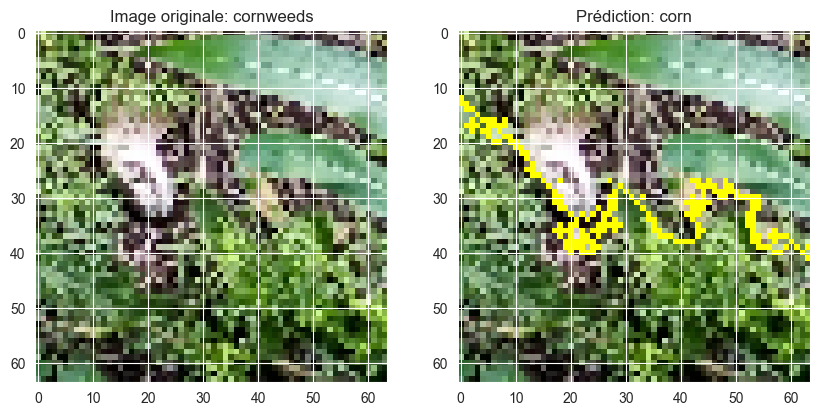

In [63]:
img = test_images[0]
label = test_labels[0]

explanation = explainer.explain_instance(
    img,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

pred_class = np.argmax(predict_fn(np.expand_dims(img, axis=0))[0])

temp, mask = explanation.get_image_and_mask(
    pred_class,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Image originale: {class_names[label]}")

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"Prédiction: {class_names[pred_class]}")
plt.show()


L’explication LIME montre que le modèle se concentre principalement sur les zones de maïs pour faire sa prédiction, ce qui peut expliquer la confusion entre les classes corn et cornweeds. Il faudra peut-être améliorer la représentation des mauvaises herbes dans l’apprentissage ou utiliser des techniques de data augmentation pour mieux différencier ces deux classes.

### VGG16

In [10]:
from tensorflow.keras.applications import VGG16

base_model_vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(64, 64, 3))
base_model_vgg16.trainable = False

model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])

In [11]:
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
history_vgg16 = model_vgg16.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)


Epoch 1/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 1019s 1s/step - accuracy: 0.4429 - loss: 1.2392 - val_accuracy: 0.6626 - val_loss: 0.8322
Epoch 2/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - accuracy: 0.6283 - loss: 0.8592 - val_accuracy: 0.6764 - val_loss: 0.7719
Epoch 3/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 826s 1s/step - accuracy: 0.6573 - loss: 0.7869 - val_accuracy: 0.6909 - val_loss: 0.7447
Epoch 4/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 834s 1s/step - accuracy: 0.6788 - loss: 0.7494 - val_accuracy: 0.6932 - val_loss: 0.7241
Epoch 5/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 840s 1s/step - accuracy: 0.6901 - loss: 0.7254 - val_accuracy: 0.6999 - val_loss: 0.7137
Epoch 6/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 892s 1s/step - accuracy: 0.7001 - loss: 0.7028 - val_accuracy: 0.7044 - val_loss: 0.7002
Epoch 7/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 895s 1s/step - accuracy: 0.7076 - loss: 0.6884 - val_accuracy: 0.7066 - val_loss: 0.6943
Epoch 8/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - accuracy: 0.7128 - loss: 0.6745 - val_acc

In [13]:
base_model_vgg16.trainable = True  # Dégeler le modèle de base
for layer in base_model_vgg16.layers[:-4]:
    layer.trainable = False  # Ne ré-entraîner que les 4 dernières couches

model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(1e-5))  # LR réduit
model_vgg16.fit(train_dataset, epochs=5)


Epoch 1/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 930s 1s/step - accuracy: 0.7399 - loss: 0.6145
Epoch 2/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 938s 1s/step - accuracy: 0.7859 - loss: 0.5068
Epoch 3/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 930s 1s/step - accuracy: 0.8151 - loss: 0.4419
Epoch 4/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 933s 1s/step - accuracy: 0.8311 - loss: 0.3969
Epoch 5/5
764/764 ━━━━━━━━━━━━━━━━━━━━ 939s 1s/step - accuracy: 0.8528 - loss: 0.3600


In [15]:
test_loss, test_acc = model_vgg16.evaluate(test_dataset)
print(f'Accuracy final: {test_acc:.2%}')


13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7770 - loss: 0.5155
Accuracy final: 79.75%


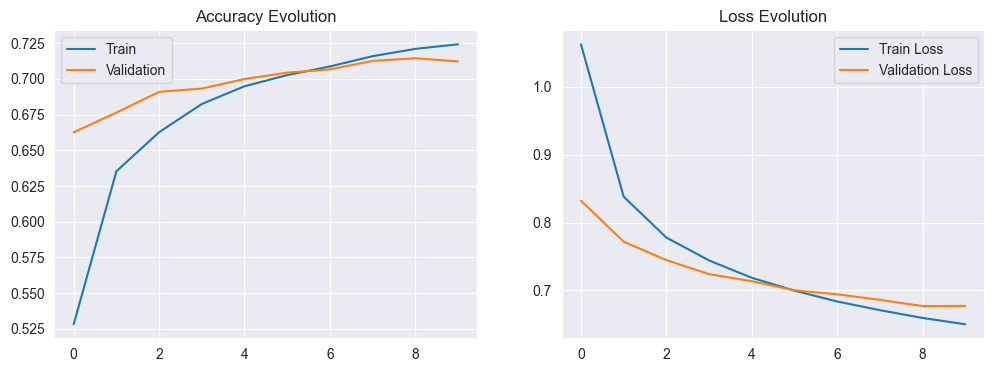

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Train')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Train Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()


Le modèle **VGG16** a atteint une précision de **79,75%** sur le jeu de test, ce qui est satisfaisant pour ce type de problème de classification d’images agricoles. Les courbes d’entraînement montrent que le modèle est stable, sans signe de surapprentissage, et qu’il généralise bien.

On constate que, même sans utiliser d’augmentation de données, **VGG16** offre de meilleures performances que le CNN custom, malgré un temps d’entraînement plus long dû à sa grande complexité (près de 138 millions de paramètres). Cette observation met en avant un compromis important : _la précision accrue se fait souvent au détriment de la vitesse d’entraînement_.

Ces résultats confirment l’intérêt du transfer learning pour améliorer la qualité des prédictions, et illustrent la nécessité de choisir le modèle adapté selon le contexte et les contraintes du projet.

## ResNet50

In [18]:
from tensorflow.keras.applications import ResNet50

base_model_resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)  # ou 75x75 si tu préfères
)
base_model_resnet50.trainable = False

model_resnet50 = tf.keras.Sequential([
    base_model_resnet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [19]:
model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_resnet50 = model_resnet50.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)


Epoch 1/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 291s 374ms/step - accuracy: 0.2965 - loss: 1.4384 - val_accuracy: 0.4401 - val_loss: 1.2437
Epoch 2/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 294s 385ms/step - accuracy: 0.4263 - loss: 1.2448 - val_accuracy: 0.4614 - val_loss: 1.1896
Epoch 3/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 298s 390ms/step - accuracy: 0.4432 - loss: 1.2088 - val_accuracy: 0.4636 - val_loss: 1.1720
Epoch 4/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 308s 403ms/step - accuracy: 0.4572 - loss: 1.1906 - val_accuracy: 0.4793 - val_loss: 1.1488
Epoch 5/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 321s 419ms/step - accuracy: 0.4614 - loss: 1.1765 - val_accuracy: 0.4782 - val_loss: 1.1385
Epoch 6/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 330s 432ms/step - accuracy: 0.4677 - loss: 1.1627 - val_accuracy: 0.4890 - val_loss: 1.1315
Epoch 7/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 332s 435ms/step - accuracy: 0.4669 - loss: 1.1571 - val_accuracy: 0.4961 - val_loss: 1.1233
Epoch 8/10
764/764 ━━━━━━━━━━━━━━━━━━━━ 333s 436ms/step - accuracy: 0.4746 -

In [20]:
test_loss, test_acc = model_resnet50.evaluate(test_dataset)
print(f'Accuracy final: {test_acc:.2%}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - accuracy: 0.4433 - loss: 1.1795
Accuracy final: 44.75%


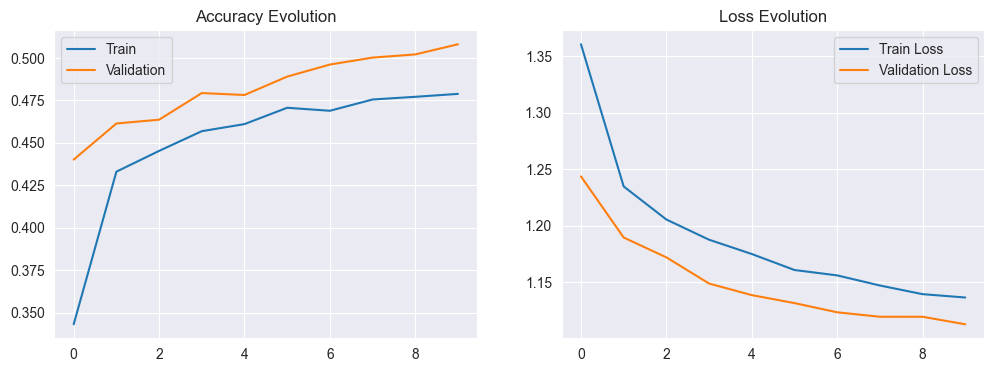

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='Train')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()


L’accuracy finale obtenue avec ResNet50 est de 44,75%, ce qui est nettement inférieur à celle de VGG16 qui atteint environ 80%. Le modèle a certes été plus rapide à entraîner, mais il n’a pas su extraire efficacement les caractéristiques nécessaires à la classification des images.

Les courbes d’apprentissage montrent que la précision reste basse sur l’ensemble de validation et que la perte diminue lentement, sans jamais atteindre un niveau satisfaisant. Il n’y a pas de signe de surapprentissage, mais le modèle ne parvient tout simplement pas à bien généraliser sur ce jeu de données.

Ce résultat montre que, dans cette configuration, ResNet50 n’est pas adapté à la tâche, contrairement à VGG16 qui offre de bien meilleures performances.